# Veri Ön İşleme, Temizlik ve Görselleştirme

**Hazırlayan:** Ramazan Bozkurt

Bu notebook, projenin temelini oluşturan veri hazırlık aşamasını içerir. `data.csv` dosyasındaki ham veri alınır, sütunlar düzenlenir, hatalı veriler temizlenir ve eksik alanlar **Yapay Zeka Destekli (Decision Tree)** yöntemlerle doldurulur. Ayrıca verinin yapısını anlamak için görselleştirme çalışmaları yapılır.

## 1. Kütüphanelerin Yüklenmesi
Veri işleme, makine öğrenmesi ve görselleştirme için gerekli kütüphaneler yüklenir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Makine Öğrenmesi Araçları (Sadece temizlik için)
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Uyarıları Kapat
import warnings
warnings.filterwarnings('ignore')

# Grafik Ayarları
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


## 2. Veri Yükleme ve İlk Bakış
Ham veri setini okuyup ilk 5 satırına ve genel bilgilerine bakıyoruz.

In [2]:
print("-> Ham veri okunuyor: data.csv")
try:
    df = pd.read_csv('data.csv')
    print(f"   Veri Boyutu: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("HATA: 'data.csv' bulunamadı! Dosya yolunu kontrol edin.")

-> Ham veri okunuyor: data.csv
   Veri Boyutu: (30000, 17)


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,marka,tax(£),fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,Kamiq,2019.0,21990,Semi-Auto,563,Diesel,145.0,52.3,1.6,skoda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q5,2016.0,20498,Semi-Auto,33657,Diesel,200.0,47.1,2.0,audi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Touareg,2019.0,39995,Semi-Auto,7000,Diesel,145.0,34.5,3.0,vw,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aygo,2019.0,8690,Manual,2438,Petrol,145.0,56.5,1.0,toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S-MAX,2020.0,34498,Semi-Auto,4623,Diesel,145.0,43.5,2.0,ford,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Temel Temizlik İşlemleri
Bu aşamada sütun isimlerindeki bozukluklar giderilir ve sayısal olması gereken sütunlar (Fiyat, KM vb.) zorla sayısal tipe dönüştürülür.

In [3]:
if 'df' in locals():
    # 1. Sütun İsimlerini Düzeltme (Küçük harf, boşluk yerine _, parantez silme)
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '', regex=False).str.replace(')', '', regex=False).str.replace('£', '_gbp', regex=False)

    # 2. Sayısal Dönüşümler
    # 'coerce' parametresi ile sayıya dönüşemeyen (hatalı metin içeren) veriler NaN yapılır.
    cols_to_numeric = ['price', 'mileage', 'mileage2', 'enginesize', 'engine_size', 'engine_size2', 'tax', 'tax_gbp']
    for col in cols_to_numeric:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    print("   Sütun isimleri düzeltildi ve sayısal dönüşümler yapıldı.")

   Sütun isimleri düzeltildi ve sayısal dönüşümler yapıldı.


## 4. Sütun Birleştirme (Coalesce)
Veri setinde aynı bilgiyi taşıyan ancak farklı isimlerle (örn: `tax` ve `tax_gbp`) kaydedilmiş sütunlar birleştirilerek tek bir temiz sütun oluşturulur.

In [4]:
if 'df' in locals():
    # Mileage (Kilometre) Birleştirme
    if 'mileage' in df.columns and 'mileage2' in df.columns:
        df['mileage_final'] = df['mileage'].fillna(df['mileage2'])
    else:
        df['mileage_final'] = df.get('mileage', pd.Series())

    # Tax (Vergi) Birleştirme
    if 'tax' in df.columns and 'tax_gbp' in df.columns:
        df['tax_final'] = df['tax'].fillna(df['tax_gbp'])
    else:
        df['tax_final'] = df.get('tax', pd.Series())

    # Engine Size (Motor Hacmi) Birleştirme
    if 'enginesize' in df.columns and 'engine_size' in df.columns and 'engine_size2' in df.columns:
        df['engine_size_final'] = df['enginesize'].fillna(df['engine_size']).fillna(df['engine_size2'])
    else:
        df['engine_size_final'] = df.get('enginesize', pd.Series())

    # Fuel Type (Yakıt Tipi) Birleştirme
    if 'fueltype' in df.columns and 'fuel_type' in df.columns and 'fuel_type2' in df.columns:
        df['fuel_type_final'] = df['fueltype'].fillna(df['fuel_type']).fillna(df['fuel_type2'])
    else:
        df['fuel_type_final'] = df.get('fueltype', pd.Series())

    # 4. Gereksiz Ham Sütunları Silme
    cols_to_drop = ['mileage', 'mileage2', 'tax', 'tax_gbp', 'enginesize', 'engine_size', 'engine_size2', 'fueltype', 'fuel_type', 'fuel_type2', 'reference']
    df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

    print("   Dağınık sütunlar birleştirildi ve gereksizler silindi.")

   Dağınık sütunlar birleştirildi ve gereksizler silindi.


## 5. Özellik Mühendisliği ve Hedef Temizliği
Araç üretim yılından `Araç Yaşı` türetilir ve hedef değişkenimiz olan `Price` sütunu boş olan satırlar (tahmin edilemeyeceği için) silinir.

In [5]:
if 'df' in locals():
    # Araç Yaşı Hesaplama
    current_year = 2025
    df['car_age'] = current_year - df['year']
    
    # Hedef değişken (Fiyat) boşsa o satırı sil
    original_len = len(df)
    df.dropna(subset=['price'], inplace=True)
    print(f"   Fiyatı olmayan {original_len - len(df)} satır silindi.")
    print(f"   Güncel Boyut: {df.shape}")

   Fiyatı olmayan 2480 satır silindi.
   Güncel Boyut: (27520, 11)


## 6. Eksik Veri Analizi (Görselleştirme)
Hangi sütunlarda ne kadar eksik veri olduğunu görsel olarak inceliyoruz. Bu, uygulayacağımız doldurma stratejisinin önemini gösterir.

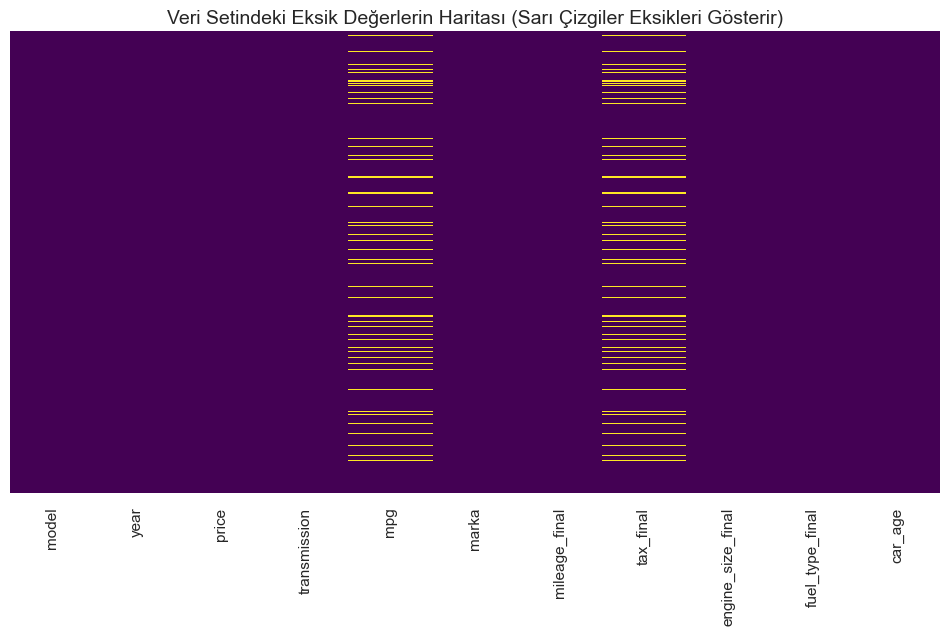

Eksik Değer Sayıları:
model                   0
year                    0
price                   0
transmission            0
mpg                  2329
marka                   0
mileage_final           0
tax_final            2329
engine_size_final       0
fuel_type_final         0
car_age                 0
dtype: int64


In [6]:
if 'df' in locals():
    # Eksik veri haritası (Heatmap)
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Veri Setindeki Eksik Değerlerin Haritası (Sarı Çizgiler Eksikleri Gösterir)', fontsize=14)
    plt.show()

    # Eksik veri sayılarını yazdır
    print("Eksik Değer Sayıları:")
    print(df.isnull().sum())

## 7. Akıllı Eksik Veri Doldurma (Smart Imputation with Decision Tree)

Burası projenin en kritik veri ön işleme adımıdır. Eksik olan kategorik veriler (örneğin Marka bilgisi yoksa), aracın diğer özelliklerine (motor, fiyat, yaş vb.) bakılarak **Decision Tree** modeli ile tahmin edilir.

Bu işlem `for` döngüsü içinde her kategorik sütun için otomatik yapılır.

In [7]:
if 'df' in locals():
    print("-> Akıllı Eksik Veri Doldurma Başlıyor (Decision Tree)...")

    # Kategorik sütunları tek tek kontrol et
    for target_col in df.columns:
        # Sadece 'object' tipinde ve eksik değeri olanlarla ilgilen
        if df[target_col].dtype == 'object' and df[target_col].isnull().sum() > 0:
            
            print(f"   ... '{target_col}' tahmin ediliyor ...")
            
            # 1. Veriyi Ayır: Dolu olanlar (Eğitim) ve Boş olanlar (Tahmin)
            train_df = df[df[target_col].notnull()]
            predict_df = df[df[target_col].isnull()]
            
            # 2. Özellikleri Belirle (Hedef ve Fiyat hariç her şey)
            features = [c for c in df.columns if c != target_col and c != 'price']
            
            X_train_imp = train_df[features]
            y_train_imp = train_df[target_col]
            X_predict_imp = predict_df[features]

            # 3. Pipeline Kur: Eksikleri Medyanla Doldur -> Encode Et -> Karar Ağacı ile Öğren
            cat_cols_imp = [c for c in X_train_imp.columns if X_train_imp[c].dtype == 'object']
            num_cols_imp = [c for c in X_train_imp.columns if X_train_imp[c].dtype in ['int64', 'float64']]

            imputer_pipe = Pipeline(steps=[
                ('preprocessor', ColumnTransformer(transformers=[
                    ('num', SimpleImputer(strategy='median'), num_cols_imp),
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_imp)
                ])),
                ('classifier', DecisionTreeClassifier(random_state=42)) # Base Model kullanıyoruz
            ])

            # 4. Eğit ve Tahmin Et
            imputer_pipe.fit(X_train_imp, y_train_imp)
            predicted_values = imputer_pipe.predict(X_predict_imp)
            
            # 5. Tahminleri Yerine Yaz
            df.loc[df[target_col].isnull(), target_col] = predicted_values

    # Geriye kalan sayısal eksikleri 'Medyan' ile doldur
    num_cols = [c for c in df.columns if df[c].dtype in ['int64', 'float64'] and c != 'price']
    df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])

    print("   Tüm eksik veriler başarıyla dolduruldu.")

-> Akıllı Eksik Veri Doldurma Başlıyor (Decision Tree)...
   Tüm eksik veriler başarıyla dolduruldu.


## 8. Temizlik Sonrası Kontrol ve Kayıt
Verinin son halini kontrol edip `cleaned_data.csv` olarak kaydediyoruz.

In [8]:
if 'df' in locals():
    # Son kontrol: Eksik değer kaldı mı?
    print("\nTemizlik Sonrası Eksik Değer Sayısı:")
    print(df.isnull().sum().sum()) # 0 Olmalı
    
    # Dosyayı Kaydet
    output_file = 'cleaned_data.csv'
    df.to_csv(output_file, index=False)
    print(f"\n-> Temizlenmiş veri '{output_file}' dosyasına kaydedildi.")
    
    # İlk 5 satırı göster
    display(df.head())


Temizlik Sonrası Eksik Değer Sayısı:
0

-> Temizlenmiş veri 'cleaned_data.csv' dosyasına kaydedildi.


,model,year,price,transmission,mpg,marka,mileage_final,tax_final,engine_size_final,fuel_type_final,car_age
0,Kamiq,2019.0,21990.0,Semi-Auto,52.3,skoda,563.0,145.0,1.6,Diesel,6.0
1,Q5,2016.0,20498.0,Semi-Auto,47.1,audi,33657.0,200.0,2.0,Diesel,9.0
2,Touareg,2019.0,39995.0,Semi-Auto,34.5,vw,7000.0,145.0,3.0,Diesel,6.0
3,Aygo,2019.0,8690.0,Manual,56.5,toyota,2438.0,145.0,1.0,Petrol,6.0
4,S-MAX,2020.0,34498.0,Semi-Auto,43.5,ford,4623.0,145.0,2.0,Diesel,5.0


# Hiyerarşik Kümeleme (Agglomerative Clustering) ve Segmentasyon Analizi

**Hazırlayan:** Ramazan Bozkurt
**Ders:** Veri Madenciliği

Bu çalışma, araç veri seti üzerinde **Gözetimsiz Öğrenme (Unsupervised Learning)** tekniklerinden biri olan **Agglomerative Clustering** yöntemini uygular. Amaç, araçları benzerliklerine göre doğal gruplara (segmentlere) ayırmak ve bu grup bilgisini (`segment_cluster`) regresyon modelleri için yeni bir **öznitelik (feature)** olarak türetmektir.

## 1. Kütüphanelerin Yüklenmesi
Veri işleme, kümeleme algoritmaları ve gelişmiş görselleştirme (Dendrogram, PCA) için gerekli kütüphaneler yüklenir.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Grafik Ayarları
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


## 2. Veri Hazırlığı ve Ölçekleme (Scaling)
Kümeleme algoritmaları **mesafe temelli** (Öklid mesafesi vb.) çalıştığı için verilerin aynı ölçekte olması hayati önem taşır. Bu adımda:
1.  Temizlenmiş veri (`cleaned_data.csv`) okunur.
2.  Hedef değişken (`price`) çıkarılır (Modelin kopya çekmemesi için).
3.  Kategorik veriler **One-Hot Encoding**, sayısal veriler **StandardScaler** ile dönüştürülür.

In [10]:
try:
    df = pd.read_csv('cleaned_data.csv')
    print(f"-> Veri okundu. Boyut: {df.shape}")
except FileNotFoundError:
    print("HATA: 'cleaned_data.csv' bulunamadı. Lütfen önce veri temizleme kodunu çalıştırın!")
    df = None

if df is not None:
    # Fiyatı çıkar (Clustering feature'ları sadece araç özellikleri olmalı)
    X = df.drop(columns=['price'])
    
    # Sütun tiplerini ayır
    cat_cols = [c for c in X.columns if X[c].dtype == 'object']
    num_cols = [c for c in X.columns if X[c].dtype in ['int64', 'float64']]

    # Dönüşüm Pipeline'ı
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

    print("-> Veri ölçekleniyor ve dönüştürülüyor...")
    X_prepared = preprocessor.fit_transform(X)
    print(f"-> İşlem tamam. Matris Boyutu: {X_prepared.shape}")

-> Veri okundu. Boyut: (27520, 11)
-> Veri ölçekleniyor ve dönüştürülüyor...
-> İşlem tamam. Matris Boyutu: (27520, 204)


## 3. Dendrogram Analizi (Hiyerarşik Yapı)
Veri setindeki araçların birbirine olan benzerliklerini ağaç yapısında (Dendrogram) görüntülüyoruz. Bu grafik, **"Kaç tane küme (Cluster) seçmeliyiz?"** sorusuna yanıt verir.

*Not: Performans için veri setinin ilk 2000 örneği kullanılmıştır.*

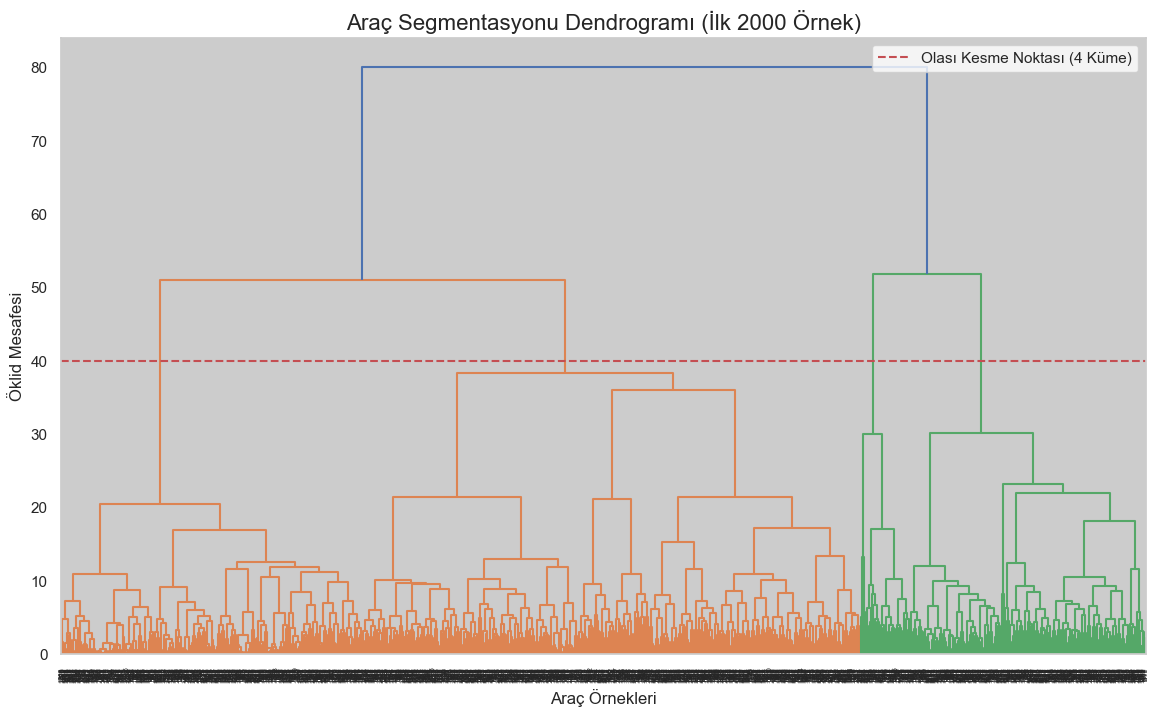

In [11]:
if df is not None:
    plt.figure(figsize=(14, 8))
    plt.title("Araç Segmentasyonu Dendrogramı (İlk 2000 Örnek)", fontsize=16)
    
    # Ward metodu varyansı minimize eder
    dend = shc.dendrogram(shc.linkage(X_prepared[:2000], method='ward'))
    
    # Kesme noktasını gösteren çizgi (Örnek: y=40)
    plt.axhline(y=40, color='r', linestyle='--', label='Olası Kesme Noktası (4 Küme)')
    plt.xlabel("Araç Örnekleri")
    plt.ylabel("Öklid Mesafesi")
    plt.legend()
    plt.show()

## 4. Agglomerative Clustering Uygulama
Dendrogram analizine dayanarak (veya iş bilgisine göre), veri setini **4 ana kümeye** ayırıyoruz. Bu işlem sonucunda her araç bir `Cluster ID` (0, 1, 2, 3) kazanır.

In [12]:
if df is not None:
    # Model Tanımlama
    n_clusters = 4
    print(f"-> Agglomerative Clustering ({n_clusters} Küme) uygulanıyor...")
    
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    clusters = cluster_model.fit_predict(X_prepared)
    
    # Orijinal veriye ekle
    df['segment_cluster'] = clusters.astype(str) # Kategorik olarak kalsın
    
    print("-> Kümeleme tamamlandı.")

-> Agglomerative Clustering (4 Küme) uygulanıyor...
-> Kümeleme tamamlandı.


## 5. Küme Sonuçlarının Analizi ve Görselleştirme
Oluşturulan kümelerin ne anlama geldiğini anlamak için çeşitli grafikler çizdiriyoruz.

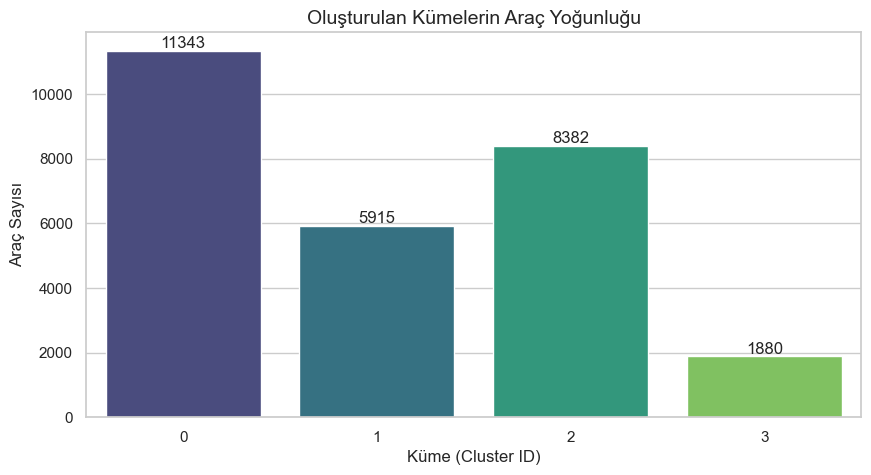

In [14]:
if df is not None:
    # Grafik 1: Kümelerin Dağılımı (Araç Sayısı)
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x='segment_cluster', palette='viridis', order=sorted(df['segment_cluster'].unique()))
    plt.title('Oluşturulan Kümelerin Araç Yoğunluğu', fontsize=14)
    plt.xlabel('Küme (Cluster ID)')
    plt.ylabel('Araç Sayısı')
    
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()

### 5.1. Kümeler ve Fiyat İlişkisi
Oluşturduğumuz segmentler fiyatı açıklıyor mu? Aşağıdaki **Boxplot**, her bir kümenin fiyat aralığını gösterir. Eğer kutular birbirinden farklı seviyelerdeyse, kümeleme işlemi fiyat tahminine katkı sağlayacaktır.

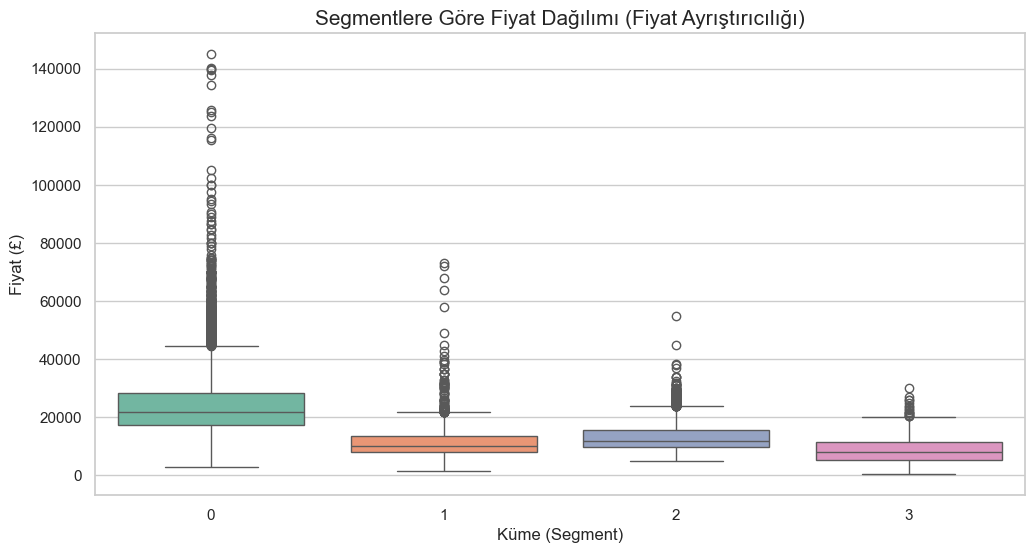

In [15]:
if df is not None:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='segment_cluster', y='price', palette='Set2', order=sorted(df['segment_cluster'].unique()))
    plt.title('Segmentlere Göre Fiyat Dağılımı (Fiyat Ayrıştırıcılığı)', fontsize=15)
    plt.xlabel('Küme (Segment)')
    plt.ylabel('Fiyat (£)')
    plt.show()

### 5.2. PCA ile 2 Boyutlu Görselleştirme
Verimiz çok boyutlu olduğu için (birçok sütun var), kümelerin nasıl ayrıştığını görmek zordur. **PCA (Principal Component Analysis)** ile veriyi 2 boyuta indirip, kümelerin uzayda nasıl durduğunu görüyoruz.

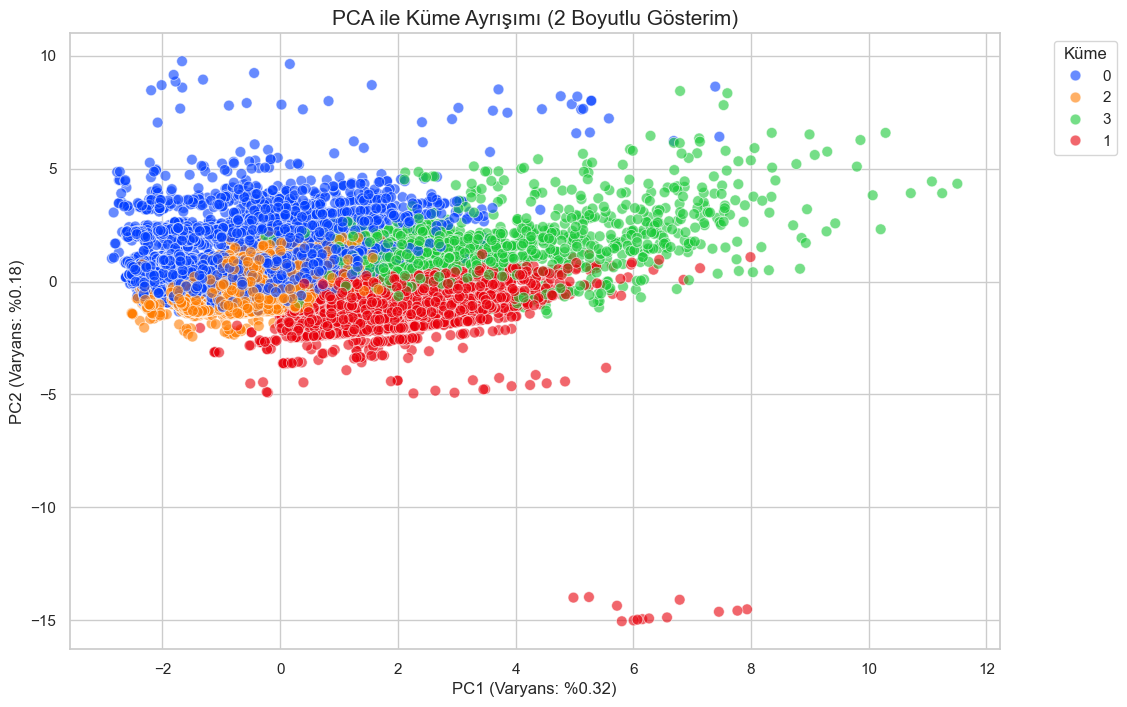

In [16]:
if df is not None:
    # PCA ile 2 boyuta indirgeme
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_prepared)
    
    # DataFrame'e çevir
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = df['segment_cluster']
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='bright', alpha=0.6, s=60)
    plt.title('PCA ile Küme Ayrışımı (2 Boyutlu Gösterim)', fontsize=15)
    plt.xlabel(f'PC1 (Varyans: %{pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 (Varyans: %{pca.explained_variance_ratio_[1]:.2f})')
    plt.legend(title='Küme', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## 6. Sonuçların Kaydedilmesi
Türetilen `segment_cluster` özelliğini içeren yeni veri seti, diğer modellerde (KNN, Decision Tree) kullanılmak üzere kaydedilir.

In [17]:
if df is not None:
    output_file = 'cleaned_data_clustered.csv'
    df.to_csv(output_file, index=False)
    print(f"-> BAŞARILI: Yeni veri seti '{output_file}' olarak kaydedildi.")
    print("-> Bu dosya artık KNN ve Decision Tree modellerinde 'Feature' olarak kullanılabilir.")

-> BAŞARILI: Yeni veri seti 'cleaned_data_clustered.csv' olarak kaydedildi.
-> Bu dosya artık KNN ve Decision Tree modellerinde 'Feature' olarak kullanılabilir.


# Decision Tree (Karar Ağacı) Regresyon Analizi

**Hazırlayan:** Ramazan Bozkurt
**Ders:** Veri Madenciliği

Bu çalışma, araç fiyat tahmini probleminde **Decision Tree Regressor** algoritmasının performansını değerlendirir. Çalışmanın odak noktası, modelin aşırı öğrenmesini (Overfitting) engellemek için yapılan **Budama (Pruning)** işlemleri ve **Kümeleme (Clustering)** tabanlı öznitelik mühendisliğinin modele etkisini ölçmektir.

## 1. Kütüphaneler ve Konfigürasyon
Gerekli makine öğrenmesi modülleri ve görselleştirme araçları yüklenir.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Grafik Ayarları
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


## 2. Model Parametreleri ve Strateji
Decision Tree modelleri, kontrol edilmezse veriyi ezberlemeye (Overfitting) çok meyillidir. Bu projede, modelin genelleme yeteneğini artırmak için **"Pre-Pruning" (Ön Budama)** stratejisi uygulanmıştır.

**Kullanılan Parametreler:**
* `max_depth=10`: Ağacın sonsuz derinleşmesini engeller (Ezberlemeyi önler).
* `min_samples_leaf=4`: Her yaprakta en az 4 araç olmasını zorunlu kılar (Gürültüyü azaltır).
* `min_samples_split=10`: Bir düğümün bölünmesi için en az 10 örnek gerektirir.

In [19]:
# Overfitting Önleyici Parametreler
dt_params = {
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'random_state': 42
}
print(f"Model Parametreleri Ayarlandı: {dt_params}")

Model Parametreleri Ayarlandı: {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4, 'random_state': 42}


## 3. Çoklu Senaryo ve A/B Testi (Kümeleme Etkisi)
Model, hem **Normal Veri** hem de **Kümelenmiş Veri (Segmentli)** üzerinde 3 farklı senaryoda eğitilerek toplam 6 farklı sonuç üretilecektir.

**Senaryolar:**
1.  **Scale Yok (Ham Veri):** Baseline model.
2.  **Scale Var (Tüm Özellikler):** Standartlaştırmanın etkisi.
3.  **Feature Selection (Top 15):** En iyi 15 özelliğin seçilmesi.

In [20]:
files = {
    "KUMELEME YOK": "cleaned_data.csv",
    "KUMELEME VAR": "cleaned_data_clustered.csv"
}

all_results = []
best_model = None
best_score = -np.inf

for durum, dosya in files.items():
    print(f"\n{'='*20}\n-> DURUM: {durum}\n-> Dosya Okunuyor: {dosya}...")
    
    try:
        df = pd.read_csv(dosya)
    except FileNotFoundError:
        print(f"HATA: {dosya} bulunamadı. Atlanıyor.")
        continue

    X = df.drop(columns=['price'])
    y = df['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    cat_cols = [c for c in X.columns if X[c].dtype == 'object']
    num_cols = [c for c in X.columns if X[c].dtype in ['int64', 'float64']]

    # --- Preprocessors ---
    preprocessor_no_scale = ColumnTransformer(transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

    preprocessor_scaled = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

    # --- Senaryo 1: Scale YOK (Baseline) ---
    pipe_no_scale = Pipeline(steps=[
        ('preprocessor', preprocessor_no_scale),
        ('regressor', DecisionTreeRegressor(**dt_params))
    ])
    pipe_no_scale.fit(X_train, y_train)
    y_pred = pipe_no_scale.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    all_results.append([durum, "Decision Tree", "Scale Yok (Ham Veri)", 
                        np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred), r2])

    # --- Senaryo 2: Scale VAR ---
    pipe_scaled = Pipeline(steps=[
        ('preprocessor', preprocessor_scaled),
        ('regressor', DecisionTreeRegressor(**dt_params))
    ])
    pipe_scaled.fit(X_train, y_train)
    y_pred = pipe_scaled.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    all_results.append([durum, "Decision Tree", "Scale Var (Tum Ozellikler)", 
                        np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred), r2])
    
    if r2 > best_score:
        best_score = r2
        best_model = pipe_scaled

    # --- Senaryo 3: Feature Selection ---
    pipe_fs = Pipeline(steps=[
        ('preprocessor', preprocessor_scaled),
        ('feature_selection', SelectKBest(score_func=f_regression, k=15)),
        ('regressor', DecisionTreeRegressor(**dt_params))
    ])
    pipe_fs.fit(X_train, y_train)
    y_pred_fs = pipe_fs.predict(X_test)
    r2 = r2_score(y_test, y_pred_fs)
    all_results.append([durum, "Decision Tree", "Feature Selection (Top 15)", 
                        np.sqrt(mean_squared_error(y_test, y_pred_fs)), mean_absolute_error(y_test, y_pred_fs), r2])

print("\nModelleme tamamlandı.")


-> DURUM: KUMELEME YOK
-> Dosya Okunuyor: cleaned_data.csv...

-> DURUM: KUMELEME VAR
-> Dosya Okunuyor: cleaned_data_clustered.csv...

Modelleme tamamlandı.


## 4. Performans Karşılaştırma Tablosu
Decision Tree, veri ölçeğinden (scaling) genellikle etkilenmez. Aşağıdaki tablo bu teoriyi doğruluyor mu? Ayrıca Kümelemenin etkisi nedir?

In [21]:
results_df = pd.DataFrame(all_results, columns=["Veri Durumu", "Model", "Senaryo", "RMSE", "MAE", "R2 Score"])

print("DECISION TREE SONUÇLARI")
display(results_df.style.background_gradient(cmap='Greens', subset=['R2 Score']))

DECISION TREE SONUÇLARI


,Veri Durumu,Model,Senaryo,RMSE,MAE,R2 Score
0,KUMELEME YOK,Decision Tree,Scale Yok (Ham Veri),3313.159163,2072.299491,0.889252
1,KUMELEME YOK,Decision Tree,Scale Var (Tum Ozellikler),3314.052563,2073.177752,0.889192
2,KUMELEME YOK,Decision Tree,Feature Selection (Top 15),3490.001476,2160.075671,0.877114
3,KUMELEME VAR,Decision Tree,Scale Yok (Ham Veri),3343.815497,2114.905589,0.887193
4,KUMELEME VAR,Decision Tree,Scale Var (Tum Ozellikler),3348.755532,2117.165627,0.886859
5,KUMELEME VAR,Decision Tree,Feature Selection (Top 15),3632.367032,2224.584477,0.866883


## 5. Grafiksel Analiz: Kümeleme Etkisi
Aşağıdaki grafik, Decision Tree modelinin **Kümeleme Olmadan** ve **Kümeleme İle** nasıl performans gösterdiğini yan yana kıyaslar.

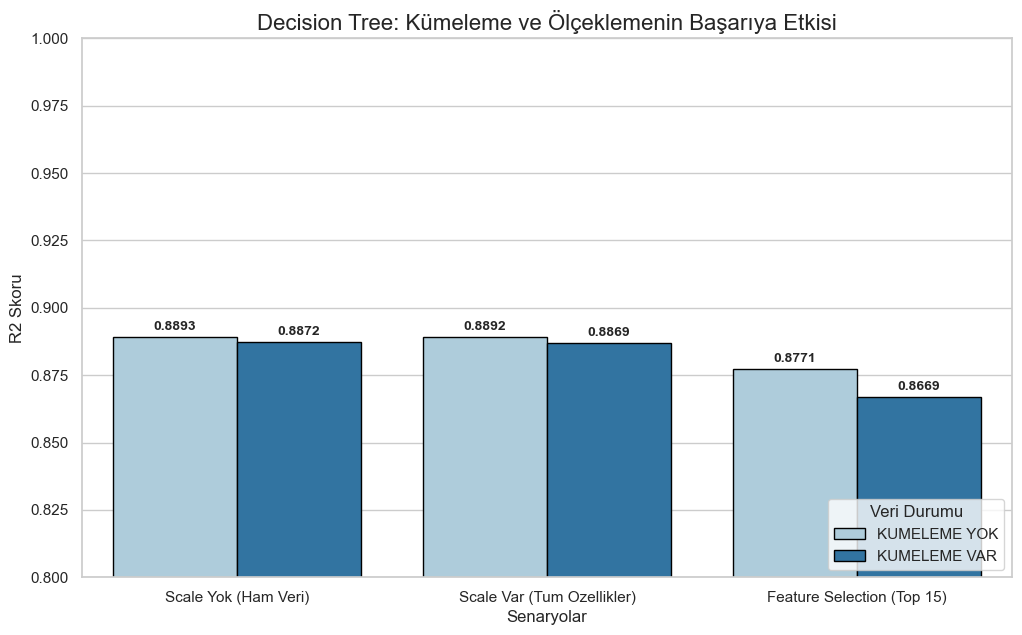

In [22]:
plt.figure(figsize=(12, 7))

ax = sns.barplot(
    data=results_df, 
    x="Senaryo", 
    y="R2 Score", 
    hue="Veri Durumu", 
    palette="Paired",
    edgecolor="black"
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3, fontsize=10, fontweight='bold')

plt.title('Decision Tree: Kümeleme ve Ölçeklemenin Başarıya Etkisi', fontsize=16)
plt.xlabel('Senaryolar', fontsize=12)
plt.ylabel('R2 Skoru', fontsize=12)
plt.ylim(0.8, 1.0) # Farkları daha iyi görmek için zoom
plt.legend(title='Veri Durumu', loc='lower right')
plt.show()

## 6. En İyi Modelin Kaydedilmesi
Analiz sonucunda en yüksek R2 skorunu veren model `decision_tree_final_model.pkl` olarak kaydedilir.

In [23]:
if best_model is not None:
    print(f"-> En iyi R2 Skoru: {best_score:.4f}")
    joblib.dump(best_model, 'decision_tree_final_model.pkl')
    print("-> Model başarıyla kaydedildi: decision_tree_final_model.pkl")

-> En iyi R2 Skoru: 0.8892
-> Model başarıyla kaydedildi: decision_tree_final_model.pkl


# KNN Regresyon Modeli: Kapsamlı Karşılaştırma ve Analiz

**Hazırlayan:** Nurettin Kaplan
**Ders:** Veri Madenciliği

Bu çalışma, araç fiyat tahmini için **K-Nearest Neighbors (KNN)** algoritmasının performansını derinlemesine analiz eder. Çalışmanın özgün yanı, sadece model parametrelerini değil, **Veri Ön İşleme Tekniklerinin** (Ölçekleme, Özellik Seçimi) ve **Veri Zenginleştirmenin** (Kümeleme/Clustering) modele olan etkisini **A/B Testi** mantığıyla kıyaslamasıdır.

## 1. Kütüphanelerin Yüklenmesi ve Ayarlar
Veri manipülasyonu, görselleştirme ve makine öğrenmesi için gerekli kütüphaneler yüklenir. Grafiklerin estetik görünmesi için `seaborn` teması ayarlanır.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-Learn Modülleri
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Uyarıları Kapatma
import warnings
warnings.filterwarnings('ignore')

# Grafik Ayarları
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


## 2. Veri Keşfi: Kümelemenin Fiyata Etkisi
Modellemeye geçmeden önce, eğer elimizde kümelenmiş veri (`cleaned_data_clustered.csv`) varsa, oluşturulan segmentlerin (Cluster ID) araç fiyatlarıyla nasıl bir ilişkisi olduğuna görsel olarak bakıyoruz. Bu, kümelemenin modele katkı sağlayıp sağlamayacağı hakkında ipucu verir.

-> Kümelenmiş veri bulundu. Segment analizi yapılıyor...


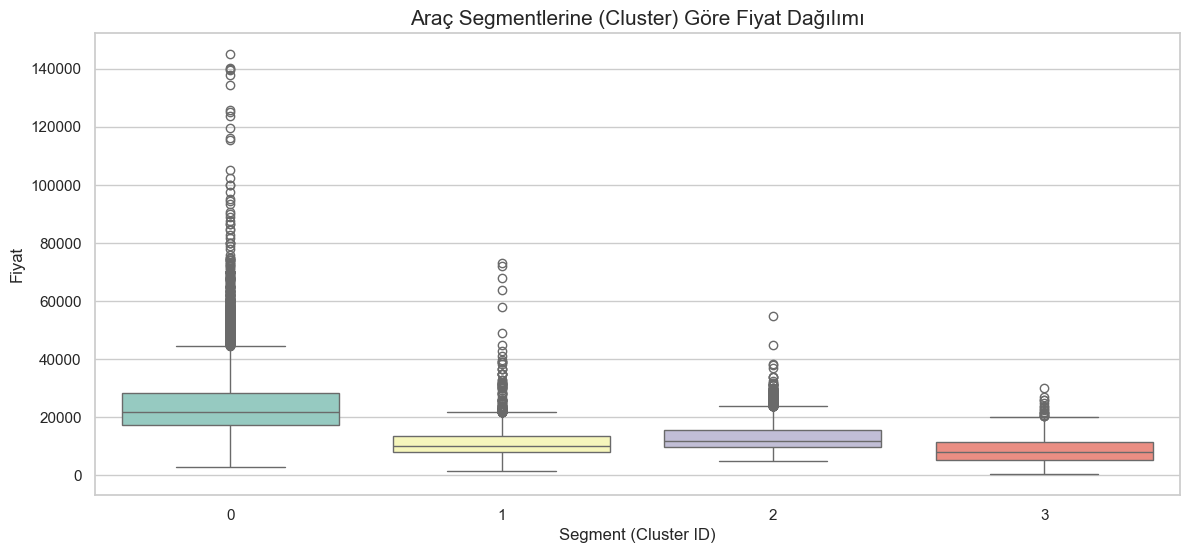

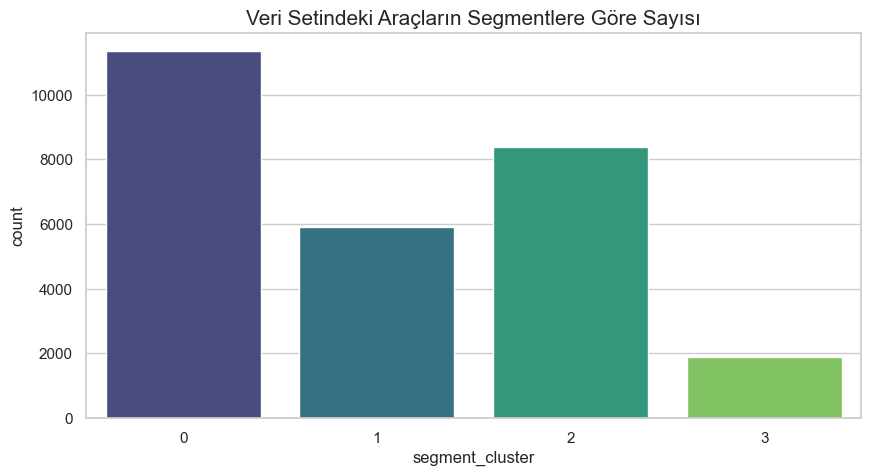

In [25]:
try:
    df_viz = pd.read_csv('cleaned_data_clustered.csv')
    if 'segment_cluster' in df_viz.columns:
        print("-> Kümelenmiş veri bulundu. Segment analizi yapılıyor...")
        
        # Kümelerin Fiyat Dağılımı (Boxplot)
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=df_viz, x='segment_cluster', y='price', palette='Set3')
        plt.title('Araç Segmentlerine (Cluster) Göre Fiyat Dağılımı', fontsize=15)
        plt.xlabel('Segment (Cluster ID)')
        plt.ylabel('Fiyat')
        plt.show()
        
        # Kümelerin Yoğunluğu (Countplot)
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df_viz, x='segment_cluster', palette='viridis')
        plt.title('Veri Setindeki Araçların Segmentlere Göre Sayısı', fontsize=15)
        plt.show()
    else:
        print("-> Veri setinde 'segment_cluster' sütunu bulunamadı.")
except FileNotFoundError:
    print("-> Görselleştirme için 'cleaned_data_clustered.csv' bulunamadı. Bu adım atlanıyor.")

## 3. Çoklu Senaryo Modelleme Döngüsü
Bu bölüm projenin kalbidir. Kod, **iki farklı veri setini** (Kümeleme Var / Yok) sırayla alır ve her biri için **üç farklı makine öğrenmesi pipeline'ını** çalıştırır:

1.  **Scale Yok (Ham Veri):** Baseline (Taban) skorunu görmek için.
2.  **Scale Var (Tüm Özellikler):** KNN için kritik olan standardizasyon etkisi.
3.  **Feature Selection (Top 15):** `SelectKBest` ile en iyi 15 özelliği seçerek gürültüyü azaltma denemesi.

Tüm sonuçlar karşılaştırma için saklanır.

In [26]:
# Test edilecek dosyalar
files = {
    "KUMELEME YOK": "cleaned_data.csv",
    "KUMELEME VAR": "cleaned_data_clustered.csv"
}

all_results = []
best_model = None
best_score = -np.inf
best_model_name = ""

for durum, dosya in files.items():
    print(f"\n{'='*20}\n-> DURUM: {durum}\n-> Dosya Okunuyor: {dosya}...")
    
    try:
        df = pd.read_csv(dosya)
    except FileNotFoundError:
        print(f"HATA: {dosya} bulunamadı, bu adım atlanıyor.")
        continue

    # X ve y ayırma
    X = df.drop(columns=['price'])
    y = df['price']

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Kategorik ve Sayısal Sütunlar
    cat_cols = [c for c in X.columns if X[c].dtype == 'object']
    num_cols = [c for c in X.columns if X[c].dtype in ['int64', 'float64']]

    # --- Preprocessor Tanımları ---
    # 1. Scale YOK
    preprocessor_no_scale = ColumnTransformer(transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

    # 2. Scale VAR (StandardScaler)
    preprocessor_scaled = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])
    
    # --- Senaryo 1: Scale YOK (Ham Veri) ---
    print(f"   -> Senaryo 1: Scale Yok (Eğitiliyor...)")
    pipe_no_scale = Pipeline(steps=[
        ('preprocessor', preprocessor_no_scale),
        ('regressor', KNeighborsRegressor(n_neighbors=5))
    ])
    pipe_no_scale.fit(X_train, y_train)
    y_pred = pipe_no_scale.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    all_results.append([
        durum, "KNN", "Scale Yok (Ham Veri)",
        np.sqrt(mean_squared_error(y_test, y_pred)),
        mean_absolute_error(y_test, y_pred),
        r2
    ])

    # --- Senaryo 2: Scale VAR (Tüm Özellikler) ---
    print(f"   -> Senaryo 2: Scale Var (Eğitiliyor...)")
    pipe_scaled = Pipeline(steps=[
        ('preprocessor', preprocessor_scaled),
        ('regressor', KNeighborsRegressor(n_neighbors=5))
    ])
    pipe_scaled.fit(X_train, y_train)
    y_pred = pipe_scaled.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    all_results.append([
        durum, "KNN", "Scale Var (Tum Ozellikler)",
        np.sqrt(mean_squared_error(y_test, y_pred)),
        mean_absolute_error(y_test, y_pred),
        r2
    ])
    
    # En iyi modeli takip et
    if r2 > best_score:
        best_score = r2
        best_model = pipe_scaled
        best_model_name = f"KNN_{durum}_ScaleVar"

    # --- Senaryo 3: Feature Selection (Top 15) ---
    print(f"   -> Senaryo 3: Feature Selection (Eğitiliyor...)")
    pipe_fs = Pipeline(steps=[
        ('preprocessor', preprocessor_scaled), # KNN için scale şart
        ('feature_selection', SelectKBest(score_func=f_regression, k=15)),
        ('regressor', KNeighborsRegressor(n_neighbors=5))
    ])
    pipe_fs.fit(X_train, y_train)
    y_pred_fs = pipe_fs.predict(X_test)
    r2 = r2_score(y_test, y_pred_fs)
    all_results.append([
        durum, "KNN", "Feature Selection (Top 15)",
        np.sqrt(mean_squared_error(y_test, y_pred_fs)),
        mean_absolute_error(y_test, y_pred_fs),
        r2
    ])

print("\nModelleme süreci tamamlandı.")


-> DURUM: KUMELEME YOK
-> Dosya Okunuyor: cleaned_data.csv...
   -> Senaryo 1: Scale Yok (Eğitiliyor...)
   -> Senaryo 2: Scale Var (Eğitiliyor...)
   -> Senaryo 3: Feature Selection (Eğitiliyor...)

-> DURUM: KUMELEME VAR
-> Dosya Okunuyor: cleaned_data_clustered.csv...
   -> Senaryo 1: Scale Yok (Eğitiliyor...)
   -> Senaryo 2: Scale Var (Eğitiliyor...)
   -> Senaryo 3: Feature Selection (Eğitiliyor...)

Modelleme süreci tamamlandı.


## 4. Performans Tablosu
Tüm senaryoların sonuçlarını tek bir tabloda karşılaştırıyoruz. Renklendirme, R2 Skoruna göre (Koyu Yeşil = Daha İyi) yapılmıştır.

In [27]:
results_df = pd.DataFrame(all_results, columns=["Veri Durumu", "Model", "Senaryo", "RMSE", "MAE", "R2 Score"])

# Tabloyu renklendirerek göster
display(results_df.style.background_gradient(cmap='Greens', subset=['R2 Score']))

,Veri Durumu,Model,Senaryo,RMSE,MAE,R2 Score
0,KUMELEME YOK,KNN,Scale Yok (Ham Veri),7910.188004,5488.283394,0.368714
1,KUMELEME YOK,KNN,Scale Var (Tum Ozellikler),2489.937219,1412.279433,0.937450
2,KUMELEME YOK,KNN,Feature Selection (Top 15),3274.841272,1853.360901,0.891799
3,KUMELEME VAR,KNN,Scale Yok (Ham Veri),7851.680515,5441.806468,0.378018
4,KUMELEME VAR,KNN,Scale Var (Tum Ozellikler),2496.419257,1420.301926,0.937124
5,KUMELEME VAR,KNN,Feature Selection (Top 15),3272.164510,1845.232304,0.891975


## 5. Grafiksel Karşılaştırma: Kümeleme ve Ölçeklemenin Etkisi
Aşağıdaki grafik, **Veri Zenginleştirme (Kümeleme)** işleminin ve **Ölçeklemenin (Scaling)** model başarısı üzerindeki etkisini net bir şekilde göstermektedir.

* **X Ekseni:** Uygulanan yöntem (Scale Yok, Var, Feature Selection)
* **Y Ekseni:** R2 Başarı Skoru
* **Renkler:** Kümeleme Durumu (Var/Yok)

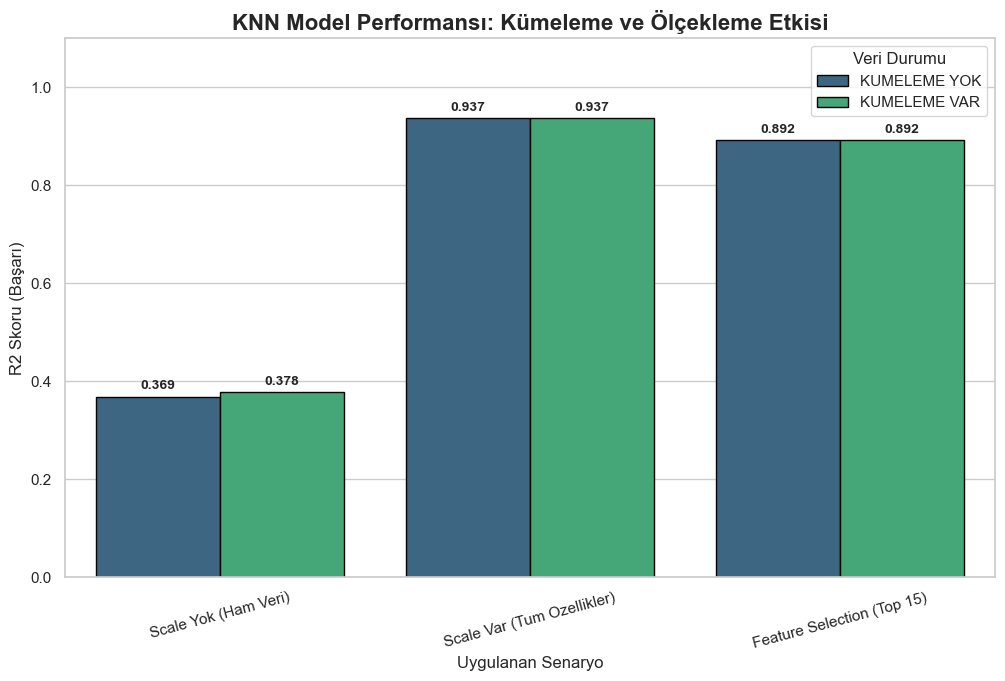

In [28]:
plt.figure(figsize=(12, 7))

# Barplot ile karşılaştırma
ax = sns.barplot(
    data=results_df, 
    x="Senaryo", 
    y="R2 Score", 
    hue="Veri Durumu", 
    palette="viridis",
    edgecolor="black"
)

# Barların üzerine skorları yazdır
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10, fontweight='bold')

plt.title('KNN Model Performansı: Kümeleme ve Ölçekleme Etkisi', fontsize=16, fontweight='bold')
plt.xlabel('Uygulanan Senaryo', fontsize=12)
plt.ylabel('R2 Skoru (Başarı)', fontsize=12)
plt.ylim(0, 1.1)  # Skoru 0-1 aralığında daha net görmek için
plt.legend(title='Veri Durumu', loc='upper right')
plt.xticks(rotation=15)
plt.show()

## 6. Sonuç ve Model Kaydı
Deneyler sonucunda en yüksek başarıyı veren model otomatik olarak belirlenir ve `knn_final_model.pkl` olarak kaydedilir.

In [29]:
if best_model is not None:
    print(f"-> En İyi Model: {best_model_name}")
    print(f"-> En İyi R2 Skoru: {best_score:.4f}")
    
    # Kaydetme
    filename = 'knn_final_model.pkl'
    joblib.dump(best_model, filename)
    print(f"-> Model başarıyla '{filename}' olarak kaydedildi.")
else:
    print("Model eğitilemedi.")

-> En İyi Model: KNN_KUMELEME YOK_ScaleVar
-> En İyi R2 Skoru: 0.9374
-> Model başarıyla 'knn_final_model.pkl' olarak kaydedildi.
